# Plotting Source Sink Cross Validation Experiment

Acknowledgements: See https://github.com/sipv/MultipanelFigures/blob/main/MultipanelFigures.ipynb for a great explanation on laying out figures in matplotlib

In [7]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [8]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
from pprint import pprint
from numpy import interp

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc, roc_curve, roc_auc_score

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import sys

sys.path.append("../../")
from episcalp.utils.standard_1020_montage import get_standard_1020_montage

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Options

In [9]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [10]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.

    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, "participants.tsv", sep="\t"))
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"
    subj_row = df[df["participant_id"] == subject]
    return subj_row

# Load Data

In [11]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [12]:
root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
deriv_path = deriv_root

In [13]:
figure_dir = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/figures")

## Load Experimental Data from JSON - output of sklearn's "cross_validate" function

In [14]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
exp_name = "fragility_benchmark"
exp_name = "spikes_benchmark"
exp_name = "tfrdelta_benchmark"
exp_name = "fragilitylobes_jhhjeff"

In [15]:
n_splits = 20

clf_name = "sporf"
# clf_name = "lr"
max_features = 4

In [16]:
pprint(list(deriv_root.glob("*.json")))

[PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv10_sporf_mtry32_exp_tfrdelta_benchmark_without_abnormaleeg.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv20_sporf_mtry7_fragilitylobes_jhhjeff_withstd.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv20_sporf_mtry4_fragilitylobes_jhhjeff.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv20_rf_mtry4_fragilitylobes_jhhjeff.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv10_sporf_mtry3_exp_spikes_benchmark_alldata.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv10_sporf_mtry12_exp_spikes_benchmark_alldata.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv10_sporf_mtry32_exp_tfrdelta_benchmark_alldata.json'),
 PosixPath('/Users/adam2392/Johns Hopkins/Scalp EEG JHH 

In [17]:
# specify the filenmae
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}.json"  # _without_abnormaleeg.json"
)
print(fname)

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/cv20_sporf_mtry4_fragilitylobes_jhhjeff.json


In [18]:
with open(fname.with_suffix(".json"), "r") as fp:
    scores = json.load(fp)

In [19]:
ch_names = get_standard_1020_montage()
print(len(ch_names))

ch_names = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    "C3",
    "C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "F7",
    "F8",
    "T3",
    "T4",
    "T5",
    "T6",
]

23


# Load Metadata DataFrame

In [80]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


# Make Plots of the Derived Dataset

## Binary Classification ROC Set up

In [21]:
def _interp_roc(fpr, tpr):
    mean_fpr = np.linspace(0, 1, 100)

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return interp_tpr, mean_fpr

In [22]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

KeyError: 'test_roc_auc'

### Making ROC Curve With Confidence Interval - Binary Classification

IndexError: list index out of range

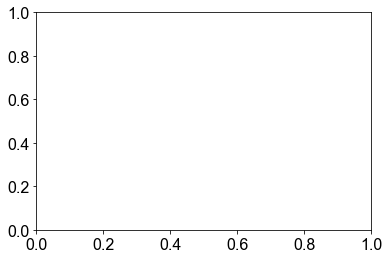

In [164]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")

## Multiclass Classification ROC Set up

In [23]:
y_classes = scores["y_classes"]

print(y_classes)

['epilepsy-abnormal-eeg', 'epilepsy-normal-eeg', 'non-epilepsy-normal-eeg']


In [24]:
y_proba = scores["test_y_pred_proba"]
y_true = scores["test_y"]

n_classes = len(np.unique(y_classes))

# construct mean/std ROC curves
fpr = collections.defaultdict(list)
tpr = collections.defaultdict(list)
roc_auc = collections.defaultdict(list)

for idx in range(n_splits):
    y_test = np.array(y_true[idx])
    y_score = np.array(y_proba[idx])

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr_, tpr_, _ = roc_curve(y_test[:, i], y_score[:, i])
        tpr_, fpr_ = _interp_roc(fpr_, tpr_)
        fpr[i].append(fpr_)
        tpr[i].append(tpr_)

        roc_auc[i].append(auc(fpr[i][idx], tpr[i][idx]))

    # Compute micro-average ROC curve and ROC area
    fpr_, tpr_, _ = roc_curve(y_test.ravel(), y_score.ravel())
    tpr_, fpr_ = _interp_roc(fpr_, tpr_)
    fpr["micro"].append(fpr_)
    tpr["micro"].append(tpr_)
    roc_auc["micro"].append(auc(fpr["micro"][idx], tpr["micro"][idx]))

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i][idx] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i][idx], tpr[i][idx])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"].append(all_fpr)
    tpr["macro"].append(mean_tpr)
    roc_auc["macro"].append(auc(fpr["macro"][idx], tpr["macro"][idx]))

In [28]:
print(fpr.keys())

dict_keys([0, 1, 2, 'micro', 'macro'])


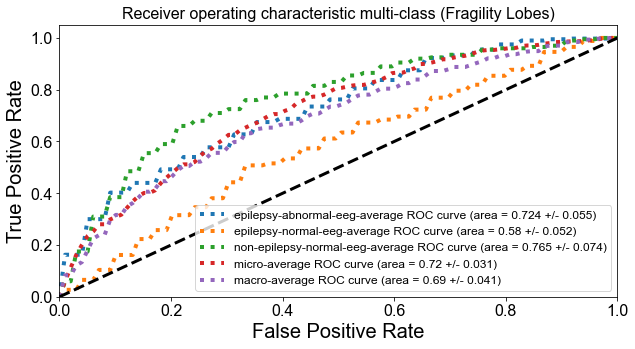

In [29]:
keys = np.unique(np.array(y_true[0]).argmax(axis=1)).tolist() + ["micro", "macro"]

fig, ax = plt.subplots(figsize=(10, 5))
lw = 3
for key in keys:
    mean_fpr = np.mean(fpr[key], axis=0)

    # compute the mean and std TPR
    mean_tpr = tpr[key]
    mean_tpr = np.mean(tpr[key], axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tpr[key], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # compute the AUCS mean +/- std
    aucs = roc_auc[key]
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # Plot all ROC curves
    if key in range(n_classes):
        key = y_classes[int(key)]
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{key}-average ROC curve (area = {mean_auc.round(3)} +/- {std_auc.round(3)})",
        #          color='deeppink',
        linestyle=":",
        linewidth=4,
    )

# ax.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

ax.plot([0, 1], [0, 1], "k--", lw=lw)
ax.set(
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver operating characteristic multi-class (Fragility Lobes)",
)
ax.legend(loc="lower right", fontsize=12)
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
plt.show()

# Print out Summary Statistics

In [167]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'test_f1_micro', 'train_f1_micro', 'test_recall_micro', 'train_recall_micro', 'test_precision_micro', 'train_precision_micro', 'test_jaccard_micro', 'train_jaccard_micro', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes'])


In [168]:
aucs = scores["test_roc_auc_ovr"]
extra_str = "_micro"

In [169]:
print(np.mean(aucs), np.std(aucs))

0.6896367521367521 0.046957344789710836


In [158]:
metric = f"test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.475 +/- 0.05216783086588716


In [159]:
metric = f"test_precision{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_precision_micro 0.5601134862299723 +/- 0.06263834879178658


In [160]:
metric = f"test_recall{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall_micro 0.44418604651162796 +/- 0.05924529861793953


In [161]:
metric = f"test_f1{extra_str}"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1_micro 0.49476700110395033 +/- 0.05828051557358843


In [163]:
# metric = "test_specificity"
# print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [24]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity,test_y,test_y_encodings
0,0.988115,0.085267,0.777778,0.736842,0.733333,0.780267,0.727273,-0.213184,0.8,0.761905,0.666667,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[non-epilepsy-normal-eeg, epilepsy-normal-eeg,..."
1,0.403923,0.084835,0.733333,0.578947,0.583333,0.759296,0.625000,-0.215559,0.5,0.555556,0.666667,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[non-epilepsy-normal-eeg, non-epilepsy-normal-..."
2,0.407709,0.084431,0.600000,0.578947,0.583333,0.715435,0.625000,-0.228083,0.5,0.555556,0.666667,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[epilepsy-normal-eeg, epilepsy-normal-eeg, epi..."
3,0.328608,0.078563,0.588889,0.631579,0.627778,0.565779,0.636364,-0.237006,0.7,0.666667,0.555556,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[non-epilepsy-normal-eeg, non-epilepsy-normal-..."
4,0.348592,0.076747,0.622222,0.473684,0.472222,0.672284,0.500000,-0.256859,0.5,0.500000,0.444444,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[non-epilepsy-normal-eeg, epilepsy-normal-eeg,..."


In [25]:
# score_df.describe().to_csv(figure_dir / f"{exp_name}_{exp_name}_metrics_meansstd.csv")

# Boxplot of Metrics

In [170]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'test_f1_micro', 'train_f1_micro', 'test_recall_micro', 'train_recall_micro', 'test_precision_micro', 'train_precision_micro', 'test_jaccard_micro', 'train_jaccard_micro', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes'])


In [180]:
metrics = [
    f"test_f1{extra_str}",
    f"test_recall{extra_str}",
    f"test_precision{extra_str}",
    f"test_roc_auc_ovr",
    f"test_balanced_accuracy",
    f"test_cohen_kappa_score",
    #     "test_neg_brier_score",
]

df = pd.DataFrame()
for metric in metrics:
    metric_scores = scores[metric]
    df[metric] = metric_scores

df = pd.melt(df, value_name="value", var_name="metric")

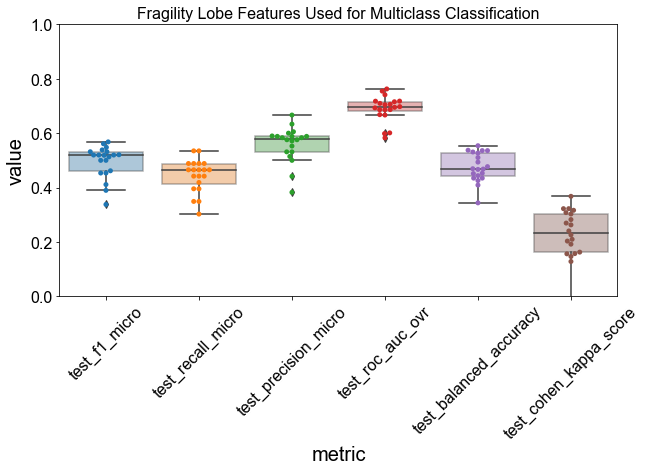

In [184]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    x="metric",
    y="value",
    #     color="gray",
    data=df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="metric",
    y="value",
    #     hue="exp_condition",
    #               color="black",
    data=df,
    ax=ax,
)
ax.set(
    ylim=[0, 1],
    title="Fragility Lobe Features Used for Multiclass Classification",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# ax.axhline(0.5, label="chance")
fig.patch.set_facecolor("white")

## Plotting Predicted Probability of Success Scores

In [200]:
print(y_classes.index("non-epilepsy-normal-eeg"))
print(y_classes)

2
['epilepsy-abnormal-eeg', 'epilepsy-normal-eeg', 'non-epilepsy-normal-eeg']


In [207]:
# TODO: modify to fit the participants framework
y_probas_epiabnorm = []
y_probas_epinorm = []
y_probas_nonepi = []
subj_list = []
folds = []

# experimental condition
exp_conditions = []
y_outcomes = []
centers = []
num_aeds = []
final_diagnosis = []
epilepsy_types = []
epilepsy_hemisphere = []
epilepsy_lobe = []

# create dataframe over the entire cross validation
for idx in range(n_splits):
    y_pred_proba = np.array(scores[f"{which_set}_y_pred_proba"][idx])
    cv_subjects = scores[f"{which_set}_subjects"][idx]
    y_true = np.array(scores["test_y"][idx]).argmax(axis=1)

    for subject in cv_subjects:
        # extract column data for each subject
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]
        aeds = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "num_aeds"
        ].values[0]
        diagnosis = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "final_diagnosis"
        ].values[0]
        epi_type = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_type"
        ].values[0]
        epi_hemisphere = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_hemisphere"
        ].values[0]
        epi_lobe = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "epilepsy_lobe"
        ].values[0]

        # this should match the original
        #         if outcome.startswith("epilepsy"):
        #             y_outcome = "epilepsy"
        #         else:
        #             y_outcome = outcome
        #         y_outcomes.append(y_outcome)
        exp_conditions.append(outcome)
        num_aeds.append(aeds)

        if subject.startswith("jhh"):
            center = "JHH"
        elif subject.startswith("jeff"):
            center = "Jefferson"
        elif subject.startswith("upmc"):
            center = "UPMC"
        centers.append(center)

    y_outcomes.extend([y_classes[idx] for idx in y_true])
    y_pred_proba_epiabnorm = y_pred_proba[:, y_classes.index("epilepsy-abnormal-eeg")]
    y_pred_proba_epinorm = y_pred_proba[:, y_classes.index("epilepsy-normal-eeg")]
    y_pred_proba_nonepi = y_pred_proba[:, y_classes.index("non-epilepsy-normal-eeg")]

    y_probas_epiabnorm.extend(y_pred_proba_epiabnorm)
    y_probas_epinorm.extend(y_pred_proba_epinorm)
    y_probas_nonepi.extend(y_pred_proba_nonepi)

    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [211]:
proba_df = pd.DataFrame(
    (
        y_probas_epiabnorm,
        y_pred_proba_epinorm,
        y_pred_proba_nonepi,
        subj_list,
        exp_conditions,
        y_outcomes,
        centers,
        folds,
        num_aeds,
    )
).T
proba_df.columns = [
    "y_proba_abnorm",
    "y_proba_epinorm",
    "y_pred_proba_nonepi",
    "subject",
    "exp_condition",
    "outcome",
    "center",
    "fold",
    "num_aeds",
]

display(proba_df.head())

,y_proba_abnorm,y_proba_epinorm,y_pred_proba_nonepi,subject,exp_condition,outcome,center,fold,num_aeds
0,0.309513,0.412673,0.210414,jhh010,non-epilepsy-normal-eeg,non-epilepsy-normal-eeg,JHH,0,2.0
1,0.679438,0.263181,0.238247,jeff202,epilepsy-abnormal-eeg,epilepsy-abnormal-eeg,Jefferson,0,NaN
2,0.352238,0.224995,0.36901,jhh112,epilepsy-normal-eeg,epilepsy-normal-eeg,JHH,0,0.0
3,0.586641,0.400973,0.572252,jeff102,epilepsy-normal-eeg,epilepsy-normal-eeg,Jefferson,0,NaN
4,0.584036,0.49203,0.355397,jhh207,epilepsy-abnormal-eeg,epilepsy-abnormal-eeg,JHH,0,2.0


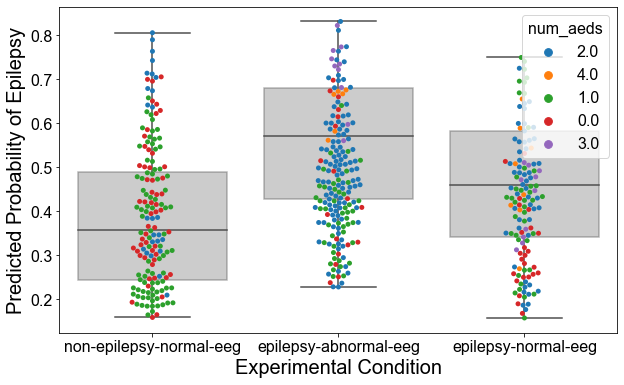

In [213]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba_abnorm",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(
    x="outcome",
    y="y_proba_abnorm",
    hue="num_aeds",
    #               color="black",
    data=proba_df,
    ax=ax,
)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Experimental Condition",
)
fig.patch.set_facecolor("white")

# fig.savefig(figure_dir / f"{exp_name}_y_pred_proba_surgical_outcomes.pdf", bbox_inches="tight")

## Boundary Split Figure

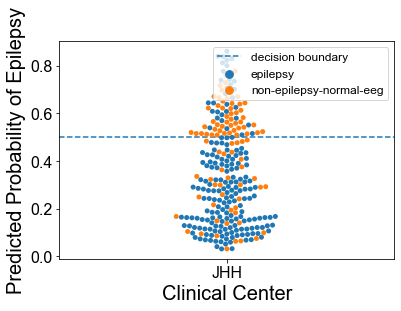

In [112]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axhline([0.5], ls="--", label="decision boundary")
# sns.boxplot(
#     x="center",
#     y="y_proba",
#     data=proba_df,
#     color="gray",
#     ax=ax,
#     boxprops=dict(alpha=0.4),
# )
sns.swarmplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="Clinical Center",
)
ax.legend(fontsize=12)
# fig.savefig(figure_dir / f"{exp_name}_boundary_split_center.pdf", bbox_inches="tight")

## Plotting Calibration Curve

In [31]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

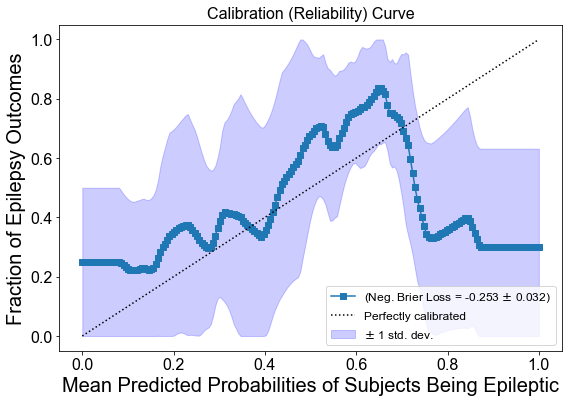

In [32]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots(figsize=(9, 6))
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"(Neg. Brier Loss = {np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)})",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Epilepsy Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Probabilities of Subjects Being Epileptic",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right", fontsize=12)

# fig.savefig(figure_dir / f"{exp_name}_calibration_curve.pdf", bbox_inches="tight")

# Look at Feature Importances

In [69]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity'])


In [82]:
importances = scores["test_importances"]
print(len(importances))
print([np.array(x).shape for x in importances])

10
[(32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5), (32, 5)]


done


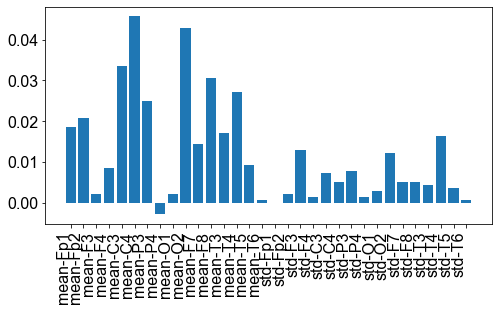

In [110]:
mean_imp = np.array([np.mean(x, axis=1) for x in importances]).mean(axis=0)
std_imp = np.array([np.std(x, axis=1) for x in importances]).mean(axis=0)

# plt.figure()
# sns.heatmap(mean_imp, xticklabels=chr)

# plt.figure()
# sns.heatmap(std_imp)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(np.arange(len(mean_imp)), mean_imp)
ax.set(
    xticks=np.arange(len(mean_imp)),
)
ax.set_xticklabels(
    [f"mean-{ch}" for ch in ch_names] + [f"std-{ch}" for ch in ch_names],
    rotation=90,
    ha="right",
)
print("done")

# Analyze Problematic Folds

Here, we will then plot i) the different metadata vs performance metric and ii) ccplots across folds ordered by performance.

In [81]:
extra_str = "_ovr"
metric = f"test_roc_auc{extra_str}"

metric_list = []
subject_list = []

for idx in range(n_splits):
    metric_list.append(scores[metric][idx])
    subject_list.append(scores["test_subjects"][idx])

In [82]:
sorted_idx = np.argsort(metric_list)
print(np.array(metric_list)[sorted_idx])
print(sorted_idx)

[0.58284349 0.59844938 0.60104388 0.66676633 0.66810581 0.68617108
 0.68641938 0.6866018  0.69310665 0.69510658 0.69764535 0.70459444
 0.70629877 0.70955711 0.715589   0.71768521 0.71804838 0.74128746
 0.75471099 0.76270396]
[ 7 11 13  9  6 17 12  3  5  2 15 19  8  0 10 16 14  1  4 18]


In [83]:
display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


In [84]:
metadata_name = [
    "sex",
    "age",
    "exp_condition",
    "num_aeds",
    "final_diagnosis",
    "epilepsy_type",
    "epilepsy_hemisphere",
    "epilepsy_lobe",
]

cv_metadata_df = pd.DataFrame()

# loop over the cv folds
for idx in sorted_idx:
    # get the subjects
    subjects = scores["test_subjects"][idx]

    fold_data = collections.defaultdict(list)
    fold_data["subject"] = subjects
    fold_data["fold"] = [idx] * len(subjects)

    # store the metric
    metric_val = scores[metric][idx]
    fold_data["metric"] = [metric_val] * len(subjects)

    # get subject-specific for each metadata component
    for name in metadata_name:
        # get the metadata from participants.tsv
        for subject in subjects:
            if not subject.startswith("sub-"):
                subject = f"sub-{subject}"
            # get metadata for this specific subjects
            subj_metadata = meta_df[meta_df["participant_id"] == subject][name].values[
                0
            ]
            fold_data[name].append(subj_metadata)
    df = pd.DataFrame(fold_data)
    #     display(df.head())
    # get the metadata for each subject
    cv_metadata_df = pd.concat((cv_metadata_df, df))

In [85]:
display(cv_metadata_df.head())

,subject,fold,metric,sex,age,exp_condition,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe
0,jhh028,7,0.582843,NaN,NaN,non-epilepsy-normal-eeg,NaN,NaN,NaN,NaN,NaN
1,jhh028,7,0.582843,NaN,NaN,non-epilepsy-normal-eeg,NaN,NaN,NaN,NaN,NaN
2,jhh221,7,0.582843,NaN,NaN,epilepsy-abnormal-eeg,1.0,epilepsy,focal,NaN,NaN
3,jhh115,7,0.582843,NaN,NaN,epilepsy-normal-eeg,2.0,epilepsy,focal,NaN,parietal
4,jeff209,7,0.582843,NaN,NaN,epilepsy-abnormal-eeg,2.0,NaN,focal,right,frontal


In [86]:
print(cv_metadata_df["epilepsy_lobe"].unique())

[nan 'parietal' 'frontal' 'temporal' 'frontal-parietal'
 'extra-temporal (unspecified)']


/Users/adam2392/miniconda3/envs/episcalp/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/adam2392/miniconda3/envs/episcalp/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


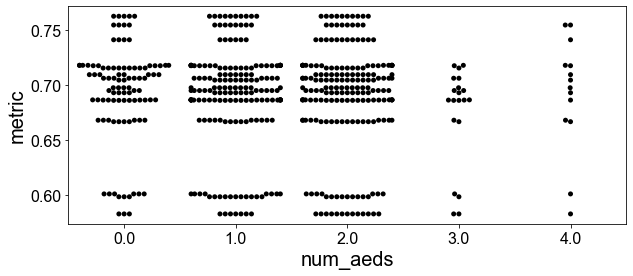

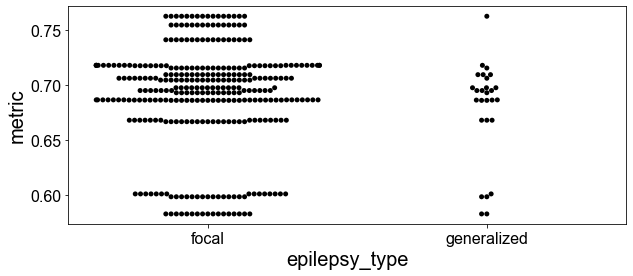

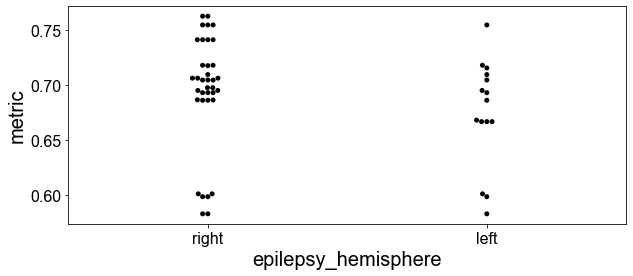

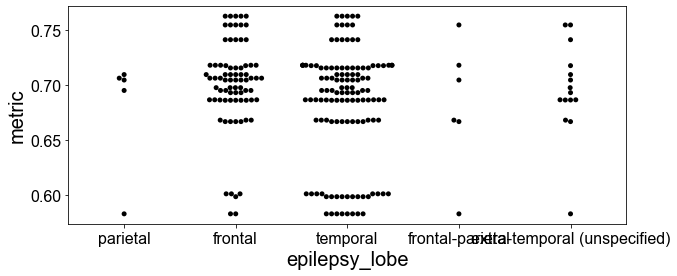

In [87]:
metadata_name = ["num_aeds", "epilepsy_type", "epilepsy_hemisphere", "epilepsy_lobe"]
for name in metadata_name:
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.swarmplot(
        x=name,
        y="metric",
        color="black",
        #                   hue="fold",
        data=cv_metadata_df,
        ax=ax,
    )

## Analyzing the problematic subjects in bad predicted folds

In [73]:
def _get_subject_intersections(indices, scores, key="test_subjects"):
    subs = []
    for idx in indices:
        subs.extend(scores[key][idx])

    # get subjects and occurrences in each fold
    subjects, counts = np.unique(subs, return_counts=True)

    sorted_idx = np.argsort(counts)[::-1]
    return subjects[sorted_idx], counts[sorted_idx]


subjects, counts = _get_subject_intersections(
    sorted_idx[:3], scores=scores, key="test_subjects"
)
# subjects, counts = _get_subject_intersections(
#     sorted_idx[:3], scores=scores, key="train_subjects"
# )

## Print out incorrectly predicted set of subjects

In [76]:
print("Consistently incorrectly annotated set of subjects")

for subject in subjects:
    subj_pred_probas = []
    for idx in range(n_splits):
        # get the index of the subject in test subjects for each fold
        if not subject in scores["test_subjects"][idx]:
            continue
        subj_idx = scores["test_subjects"][idx].index(subject)
        y_pred_proba = scores["test_y_pred_proba"][idx][subj_idx]

        subj_pred_probas.append(y_pred_proba)

    outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
        "exp_condition"
    ].values[0]

    if outcome.startswith("epilepsy"):
        outcome = 1
    elif outcome.startswith("non-epilepsy"):
        outcome = 0

    if outcome == 1 and np.mean(subj_pred_probas) > 0.5:
        continue
    elif outcome == 0 and np.mean(subj_pred_probas) < 0.5:
        continue

    print(subject)
#     print(outcome, subj_pred_probas)

Consistently incorrectly annotated set of subjects
jhh027
0 [0.6722499999999999, 0.6873666666666666, 0.6216666666666666]
jhh125
1 [0.24125000000000002, 0.29491666666666666, 0.11853333333333335, 0.15266666666666664, 0.15683333333333335]
jhh113
1 [0.3903833333333333, 0.4400833333333333, 0.5288333333333333]
jhh008
0 [0.6361666666666667, 0.66075, 0.6799999999999999, 0.7066666666666668]
jhh124
1 [0.1826666666666667, 0.23241666666666666, 0.14833333333333334, 0.28824999999999995, 0.2718333333333333, 0.13266666666666665]
jhh028
0 [0.5271999999999999, 0.5120666666666666, 0.7125999999999999, 0.33175000000000004, 0.6092000000000001]
jhh116
1 [0.43693333333333334, 0.4655833333333333]
jhh019
0 [0.6230833333333332]
jhh003
0 [0.7310833333333333, 0.6947333333333334, 0.6423666666666665, 0.6657000000000002]
jhh010
0 [0.7201666666666666, 0.7330833333333334, 0.6645000000000001, 0.46244999999999997]
jhh012
0 [0.5806666666666667, 0.6784166666666667, 0.43625]
jhh015
0 [0.5006666666666667, 0.5336166666666666,

In [18]:
for idx in range(n_splits):
    test_subs = scores["test_subjects"][idx]

    for subject in test_subs:
        outcome = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
            "exp_condition"
        ].values[0]

# McNemars Test To Compare Two Different Classification Scenarios

In [55]:
from numpy.testing import assert_array_equal

In [56]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [57]:
y_target = []
y_modelhfo = []
y_modelss = []

y_subjs = []
for idx in range(n_splits):
    y = ss_scores["test_subjects"][idx]
    hfo_y = hfo_scores["test_subjects"][idx]

    assert_array_equal(y, hfo_y)
    y_subjs.extend(y)

    y_predhfo = hfo_scores["test_y_pred_proba"][idx]
    y_predss = ss_scores["test_y_pred_proba"][idx]
    y_modelhfo.extend(y_predhfo)
    y_modelss.extend(y_predss)

In [58]:
for subject in y_subjs:
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    y_target.append(outcome)

y_target = enc.fit_transform(np.array(y_target)[:, np.newaxis]).squeeze()
y_modelss = np.array(y_modelss).round()
y_modelhfo = np.array(y_modelhfo).round()

In [59]:
tb = mcnemar_table(y_target=y_target, y_model1=y_modelss, y_model2=y_modelhfo)
print(tb)

[[98 60]
 [33  9]]


In [60]:
chi2, p = mcnemar(ary=tb, corrected=True)
print("chi-squared:", chi2)
print("p-value:", p)

chi-squared: 7.268817204301075
p-value: 0.0070161992342396284


# Plots Comparing HFO and Source Sink

In [59]:
which_set = "test"

aucs = []
precisions = []
recalls = []
specificities = []
accuracies = []
clfs = []

for clf in ["HFO", "Source-Sink"]:
    if clf == "HFO":
        scores = hfo_scores
    elif clf == "Source-Sink":
        scores = ss_scores

    for idx in range(n_splits):
        auc_ = scores[f"{which_set}_roc_auc"][idx]
        precision_ = scores[f"{which_set}_average_precision"][idx]
        acc = scores[f"{which_set}_balanced_accuracy"][idx]
        sens = scores[f"{which_set}_recall"][idx]
        spec = scores[f"{which_set}_specificity"][idx]

        aucs.append(auc_)
        precisions.append(precision_)
        accuracies.append(acc)
        recalls.append(sens)
        specificities.append(spec)
        clfs.append(clf)

comp_df = pd.DataFrame((aucs, precisions, accuracies, recalls, specificities, clfs)).T
comp_df.columns = [
    "AUC",
    "Average Precision",
    "Accuracy",
    "Sensitivity",
    "Specificity",
    "Feature",
]

In [60]:
display(comp_df.head())

,AUC,Average Precision,Accuracy,Sensitivity,Specificity,Feature
0,0.787879,0.821022,0.787879,0.666667,0.909091,HFO
1,0.656566,0.665096,0.575758,0.333333,0.818182,HFO
2,0.727273,0.636522,0.676768,0.444444,0.909091,HFO
3,0.555556,0.615104,0.414141,0.555556,0.272727,HFO
4,0.707071,0.748319,0.69697,0.666667,0.727273,HFO


In [61]:
df = pd.melt(
    comp_df,
    id_vars=["Feature"],
    value_name="Value",
    var_name="Metric",
)

display(df.head())

,Feature,Metric,Value
0,HFO,AUC,0.787879
1,HFO,AUC,0.656566
2,HFO,AUC,0.727273
3,HFO,AUC,0.555556
4,HFO,AUC,0.707071


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


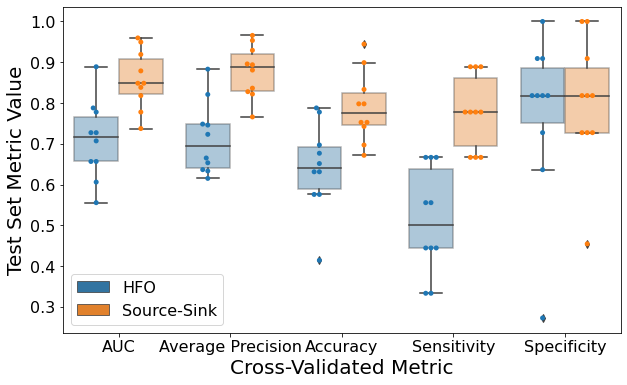

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="Metric", y="Value", hue="Feature", data=df, ax=ax, boxprops=dict(alpha=0.4)
)
sns.swarmplot(x="Metric", y="Value", hue="Feature", data=df, ax=ax, split=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(
    xlabel="Cross-Validated Metric",
    ylabel="Test Set Metric Value",
)
fig.savefig(figure_dir / "compare_metrics.pdf", bbox_inches="tight")